I attempted to reproduce results from the dataset used in [this paper](https://arxiv.org/pdf/1609.07124) using linear regression. The dataset in question is a collection of 16242 organic molecules and their simulated ground-state energies, which is the free energy in the molecule when no other exciting force is applied (for example, a photon). As features, each molecule contains 1275 values corresponding to the intermolecular Coulomb repulsion operators, which quantify the repulsion between each pair of atoms in each molecule. 

The paper used a tree-based approach, but as it turns out, it is possible to achieve similar results with PCA + linear regression.

In [59]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# the stuff I made
from models import LinearRegressionModel, PCA
from utils.data_utils import split_dataset

# Loading Data

In [60]:
# had to split dataset into 2 dataframes so I could upload it to github
filepaths = ['datasets/quantum_chemistry_dataset_0.csv', 'datasets/quantum_chemistry_dataset_1.csv']

dfs = []
for filepath in filepaths:
    df_chunk = pd.read_csv(filepath, index_col='Unnamed: 0')
    dfs.append(df_chunk)

df = pd.concat(dfs, axis=0)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


In [61]:
# extracting features as list
features = df.columns[:-2]
len(features)

1275

<Axes: >

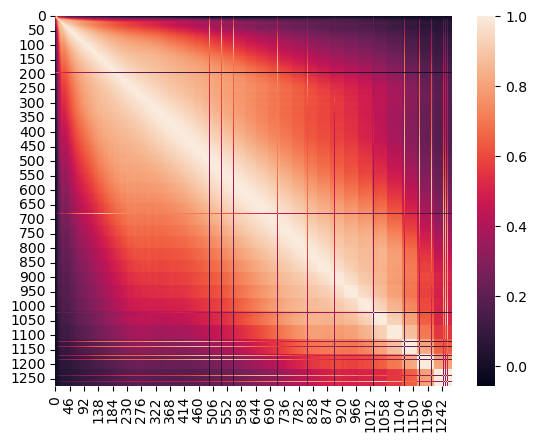

In [62]:
# visual check for multicollinearity
sns.heatmap(df[features].corr())

We can observe a high degree of multicollinearity between our 1275 features. This suggests we may need to do dimensionality reduction, but to start I'll try and fit a full linear model. 

# Attempting to Fit Full Model

In [63]:
X = df[features].values
y = df['Eat'].values # target value

# sanity check
assert len(y) == X.shape[0], 'number of samples in X does not match y'

# number of samples, number of features
X.shape, y.shape

((16242, 1275), (16242,))

In [64]:
# split dataset into train and test
X_train, y_train, X_test, y_test = split_dataset(X, y, test_size=0.2, shuffle=True)

# to save memory
del X

In [65]:
model_full = LinearRegressionModel()

try:
    model_full.fit(X_train, y_train)
except Exception as e:
    print(e)

X is ill-conditioned: condition number = 1.3924282940535234e+16. Inversion of X.T @ X will not be numerically stable. 
            Consider dimensionality reduction techniques (ex. PCA) or feature selection (ex. variance-based selection).


Hey look! How nice of me to include such a helpful error message. It turns out that when trying to fit a linear model to X, the resulting beta_hat is complete junk. If you inspect further, you'll find (X.T @ X)^(-1) @ (X.T @ X) != I, suggesting that the inverse operation failed. 

# Dimensionality Reduction with Principal Component Analysis

Now we'll try and use PCA to reduce dimensionality and see if that helps. Specifically, we'll try and use the best 100 principal components. 

In [66]:
pca = PCA(num_components=100)

# fit and transform on train data
X_train_transformed = pca.fit_transform(X_train)

# transform test data based on train data to avoid data leakage
X_test_transformed = pca.transform(X_test)

In [67]:
# number of samples, number of features
X_train_transformed.shape, X_test_transformed.shape

((12993, 100), (3249, 100))

<Axes: >

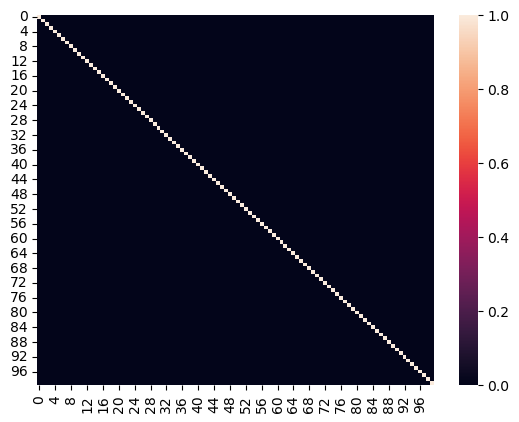

In [68]:
# feature correlations for reduced feature set
sns.heatmap(np.corrcoef(X_train_transformed.T))

Nice, looks like little to no linear correlations between our new features. Now let's try and fit a model.

In [69]:
model_reduced = LinearRegressionModel()

model_reduced.fit(X_train_transformed, y_train)

model_reduced.r_squared(X_test_transformed, y_test)

np.float64(0.9554993509450324)

Hey look, it worked!